# Predict BBT change using Kalman Filter
**Author:** Thuy Trinh

**Achievement:** 

This report attempted to implement Kalman filter algorithm in seminar note Slide 16. <br>
The implement seems to have successfully predict $y_{t|t-1}$ but for some reasons it is not yet able to apply an optimisation algorithm to obtain maximum-likihood estimates for $\theta$.

# Introduction
Aims:
1. to explain daily  fluctuations in BBT
2. to derive a predictive  distribution of menstrual cycle length that is dependent on the **current phrase** state

## Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from numpy.linalg import inv
import scipy.optimize as opt
%matplotlib inline

# Data

## Import data

In [3]:
data = pd.read_csv("bbtdata_forTask7.csv", index_col = "day")
data.head()

,bbt_subject1,bbt_subject2,bbt_subject3,bbt_subject4,bbt_subject5
day,,,,,
0,35.95,36.19,36.41,36.56,36.65
1,35.98,36.23,36.04,36.32,36.61
2,36.10,36.20,36.01,36.21,37.00
3,36.07,36.14,36.01,36.18,36.90
4,36.00,36.37,36.03,36.16,36.65


In [4]:
print("\n initial data dimension:", data.shape)
data = data.dropna()
print("\n removed NA data dimension:", data.shape)


 initial data dimension: (254, 5)

 removed NA data dimension: (254, 5)


There is no missing data in our data. <br>
We have data for records of BBT from 5 different subjects for 254 consecutive days.

# Method

The simplified state-space model for BBT time series includes two variables:
1. y(t) (t=1,...,T) : Basal body temparature
2. x(t) : oscillation component of BBT

## Explain daily fluctuation in BBT

* The oscillation component of BBT ( x(t) ) is a **latent state space variable** , i.e: a variable that cannot be observed
* The system model is : <br>
<img src="pictures/model_xt.png" width="430">

## Steps
1. Compute the theoretical value of X and Error Covariance using maths formular
2. Compute measure error covariane
3. Update estimated value of X and estimated Error Covariance

## Sudo code
<img src="pictures/KalmanFilterFlow.png">

# Implement

## Compute estimated y and its error covariance F

In [86]:
def kalmanFilter(y_observations, theta):
    ## Initialise parameters
    a = theta[0]
    b = theta[1]
    c = theta[2]
    f = theta[3]
    
    # Process / Estimation Errors
    sigma_x = theta[4]
    # Observation Errors
    sigma_y = theta[5]  # Uncertainty in the measurement
    
    # set B
    B = np.array([b, 0])
    delta_t = 0.1

    ## Apply Kalman Filter
    ## compute A
    radian = m.degrees(2 * m.pi * f * delta_t)
    A = np.array([[a * (m.cos(radian) - m.sin(radian)), 0],
                  [0, a * (m.sin(radian) - m.cos(radian))]])
    I = np.identity(2)

    # initialise values
    E = np.array([[sigma_y**2, 0],
                  [0, sigma_y**2]])

    init_x_est = np.array([(36.5-c)/b, 0])

    x_est = init_x_est
    x_est_series = []
    E_series = []

    # tobe compute from x
    KG_series = []
    y_est_series = []
    F_series = []
    
    for value in y_observations:
        # compute x_est and y_est from x_est_init
        x_est = A.dot(x_est)
        y_est = B.dot(x_est) + c

        # compute covariance of error from x_est
        E = A.dot(E).dot(A.T) + sigma_x*I
    #     print("cov_err_x_est", cov_err_x_est)
        # compute covariance of error from y_est
        F = B.dot(E).dot(B.T) + sigma_y
    #     print("cov_err_y_est", cov_err_y_est)

        # compute Kalman gain
        err_est = (value - y_est)
        KG = E.dot(B.T).dot(1/F)
    #     KG = err_est/(err_est + cov_err_y_est)

        # update x_est and error
        x_est = x_est + KG*err_est
        E = E - KG.dot(F).dot(KG.T)

        KG_series.append(KG)
        x_est_series.append(x_est)
        E_series.append(E)
        y_est_series.append(y_est)
        F_series.append(F)
        
    return (y_est_series, F_series, x_est_series, E_series, KG_series)

In [132]:
df = list(data['bbt_subject1'])

In [133]:
## display the result
y_observations = df
# theta = [-0.7, 83, 50, 100, 0.5, 0.5]
theta = [-0.7, 85, 36, 95, 0.4, 0.4]
(y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)

res = {"y_observations": y_observations,
      "y_estimated": y_est_series,
      "F": F_series,
       "x_estimated": x_est_series,
       "E": E_series,
       "KG": KG_series}
res_df = pd.DataFrame(res)
res_df.tail()

,y_observations,y_estimated,F,x_estimated,E,KG
249,36.12,36.272489,-7.170592e+114,"[0.0014117647058823422, 0.0050374373913274146]","[[3.357500225798352e+111, 6.175405695939464e+1...","[0.011764705882352941, -0.021638667708401893]"
250,36.10,36.108996,2.001288e+115,"[0.0011764705882352994, -0.004380835153811739]","[[-9.370667328446904e+111, -1.723534430473046e...","[0.011764705882352941, -0.021638667708401893]"
251,36.22,36.090830,-5.585524e+115,"[0.002588235294117665, 0.0011840250172042571]","[[2.6153209314987555e+112, 4.810325149940023e+...","[0.011764705882352941, -0.021638667708401896]"
252,36.16,36.199825,1.558901e+116,"[0.0018823529411764715, -0.0002136797341939059]","[[-7.2992705161684146e+112, -1.342545158311380...","[0.011764705882352941, -0.021638667708401893]"
253,36.20,36.145327,-4.350838e+116,"[0.0023529411764706483, -0.0009889556461514268]","[[2.037201225536512e+113, 3.746997231835363e+1...","[0.011764705882352941, -0.021638667708401903]"


Text(0.5, 0, 'days')

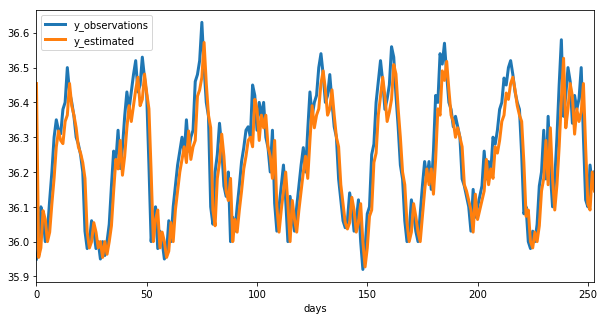

In [134]:
# visualise the result
res_df[['y_observations', "y_estimated"]].plot(figsize=(10,5), linewidth=3, fontsize=10)
plt.xlabel('days', fontsize=10)

## Compute log likelihood

In [135]:
def logL(y_observations, theta):
    # compute y_est and F
    (y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)
    
    ## compute log likelihood value from y and F calculated above
    T = len(y_est_series)
    component_1 = -(T/2)*np.log(2*m.pi)
    component_2 = [] 
    inverse_F = []
    for value in F_series:
        if (value > 0.1 and value < 10**10): # condition to prevent inverse a value which is too large or too small
            inverse_F.append(1/value)
            component_2.append((np.log(1/value)))
        else:
            inverse_F.append(0)
            component_2.append(abs(1/value))
    inverse_F = np.array([inverse_F])
    component_2 = np.array([component_2])
    diff_y = np.array([np.array(y_observations)-np.array(y_est_series)])
    component_3 = (diff_y).dot(inverse_F.T).dot(diff_y)
    logL = component_1 + 0.5*sum(i for i in component_2) - 0.5*sum(i for i in component_3)
    
    return (logL[0])

In [136]:
logL(y_observations, theta)

-237.53617935378114

## Minimise loglikehood for optimal parameters

In [156]:
# run optimisation to estimate model parameters 
res = opt.minimize(fun = logL,
                   x0 = [0.7, 83, 36, 100, 0.5, 0.5],
                   args = df, 
                   method = 'L-BFGS-B',
                   bounds = [(-1,1), (-3000, 3000), (-5000, 5000), (-5000, 5000), (-50, 50), (-50, 50)])
print(res)

      fun: -16.265734533405894
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.01909939, 0.00040146, 0.        , 0.        , 0.        ,
       0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 84
      nit: 4
   status: 0
  success: True
        x: array([-1.0e+00, -3.0e+03,  3.6e+01,  1.0e+02,  5.0e-01,  5.0e-01])


In [157]:
opt_theta = res.x
for value in opt_theta: 
    print("\n {0:1.3f}".format(value))


 -1.000

 -3000.000

 36.000

 100.000

 0.500

 0.500


In [158]:
## display the result
y_observations = list(data['bbt_subject1'])
theta = opt_theta
(y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)

res = {"y_observations": y_observations,
      "y_estimated": y_est_series,
      "F": F_series,
       "x_estimated": x_est_series,
       "E": E_series,
       "KG": KG_series}
res_df = pd.DataFrame(res)
res_df.tail()

,y_observations,y_estimated,F,x_estimated,E,KG
249,36.12,35.631861,1.035476e+182,"[-4.000000000000027e-05, 1.0097345367724351e+19]","[[-3.8922130808141125e+175, -7.158895968012704...","[-0.0003333333333333333, 0.000613095585071387]"
250,36.10,35.852745,-5.274965e+182,"[-3.333333333333469e-05, 1.2390745675838253e+19]","[[1.9827865252025786e+176, 3.646912994222212e+...","[-0.0003333333333333333, 0.0006130955850713872]"
251,36.22,35.877287,2.687193e+183,"[-7.33333333333331e-05, 1.5205043782503174e+19]","[[-1.0100789249962121e+177, -1.857824788466491...","[-0.0003333333333333334, 0.000613095585071387]"
252,36.16,35.730032,-1.368921e+184,"[-5.3333333333333143e-05, 1.8658550701969584e+19]","[[5.145583862676618e+177, 9.464204246464827e+1...","[-0.0003333333333333333, 0.000613095585071387]"
253,36.20,35.803659,6.973610e+184,"[-6.666666666666789e-05, 2.289644931496908e+19]","[[-2.62128360790592e+178, -4.821292221681348e+...","[-0.0003333333333333333, 0.0006130955850713872]"


Text(0.5, 0, 'days')

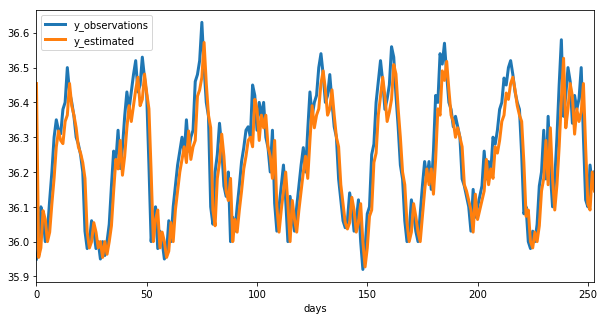

In [184]:
# visualise the result
res_df[['y_observations', "y_estimated"]].plot(figsize=(10,5), linewidth=3, fontsize=10)
plt.xlabel('days', fontsize=10)

# Results

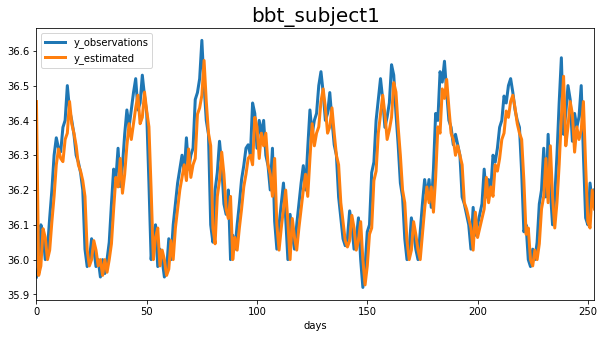

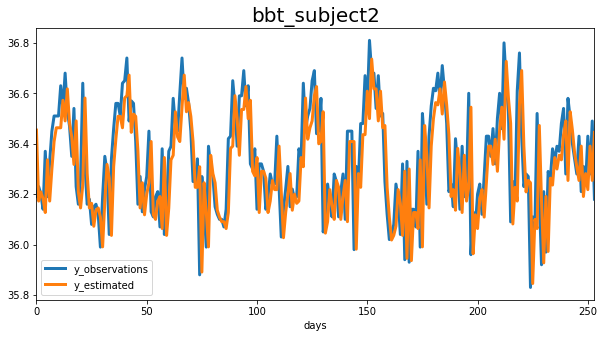

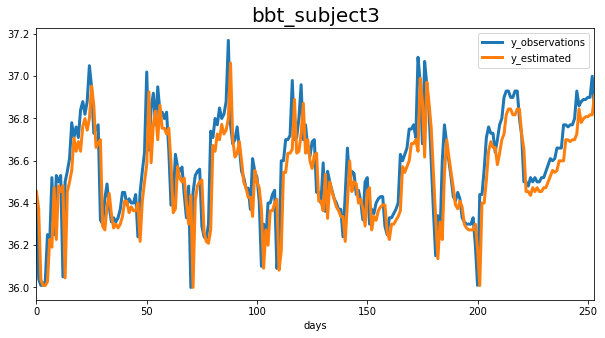

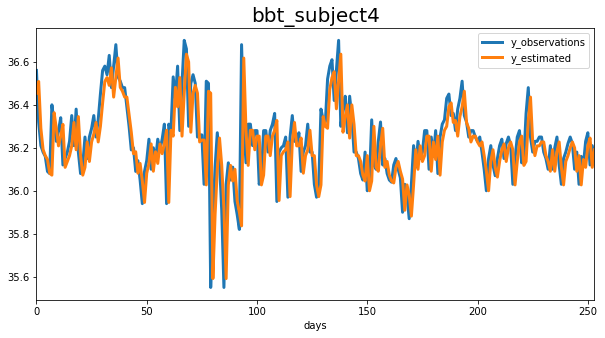

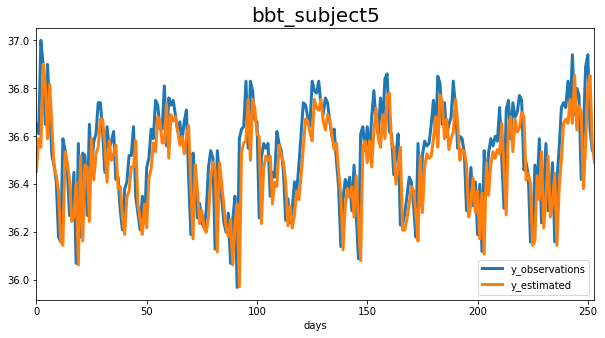

In [186]:
for col_name in list(data.columns):
    y_observations = list(data[col_name])
    theta = [-0.7, 85, 36, 95, 0.4, 0.4]
    (y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)
    
    res = {"y_observations": y_observations,
          "y_estimated": y_est_series,
          "F": F_series,
           "x_estimated": x_est_series,
           "E": E_series,
           "KG": KG_series}
    res_df = pd.DataFrame(res)
    
    # visualise the result
    res_df[['y_observations', "y_estimated"]].plot(figsize=(10,5), linewidth=3, fontsize=10, )
    plt.xlabel('days', fontsize=10)
    plt.title(col_name, fontsize=20)